In [1]:
import sys
sys.path.append('../src/')

import pandas as pd
import mlflow
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, max_error

from make_features import make_features

plt.style.use('seaborn-v0_8-darkgrid')
pd.options.mode.chained_assignment = None

LAG_END = 7
ROLLING_MEAN = 5

In [2]:
df = pd.read_csv('../data/update/data_update.csv', index_col=0)
df.index = pd.to_datetime(df.index)

X_train, X_test, y_train, y_test = make_features(df, LAG_END, ROLLING_MEAN)

In [3]:
def rmse(target, predictions):
    return mean_squared_error(target, predictions)**0.5

score_rmse = make_scorer(rmse, greater_is_better=False) 

def objective_lgbm(trial):
    max_depth = trial.suggest_int("max_depth", 2, 20)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
    n_estimators = trial.suggest_int("n_estimators", 10, 1800)

    score = cross_val_score(
        LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators), 
        X_train, 
        y_train, 
        cv=TimeSeriesSplit(n_splits=5), 
        scoring=score_rmse, 
        n_jobs=-1).mean()
    
    return score 

def vizualization(y_test, pred):
    y =  pd.Series(pred, index = y_test.index)
    result = pd.concat([y_test, y], axis=1).tail(250)
    result.plot(figsize=(17,7), title='Результаты модели');

def make_features(model):
    features_imp = pd.Series(model.feature_importances_, index=model.feature_name_).sort_values(ascending=False)
    
    fig = plt.figure(figsize=(18, 7))
    sns.barplot(x=features_imp, y=features_imp.index)
    plt.xlabel('Важность признаков', fontsize=12)
    plt.ylabel('Признаки', fontsize=12)
    plt.title('Визуализация важных признаков', fontsize=12)
    plt.show();

In [4]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_lgbm, n_trials=30)

[I 2023-10-23 12:12:08,615] A new study created in memory with name: no-name-bcd44b36-92c8-41fe-812a-89d58a94dac7


[I 2023-10-23 12:12:20,791] Trial 0 finished with value: -1.2049979428667374 and parameters: {'max_depth': 6, 'learning_rate': 0.0016857877377427233, 'n_estimators': 205}. Best is trial 0 with value: -1.2049979428667374.
[I 2023-10-23 12:12:52,339] Trial 1 finished with value: -0.8461602965612391 and parameters: {'max_depth': 11, 'learning_rate': 0.00755361445281659, 'n_estimators': 1030}. Best is trial 1 with value: -0.8461602965612391.
[I 2023-10-23 12:13:17,421] Trial 2 finished with value: -0.8463591319897542 and parameters: {'max_depth': 5, 'learning_rate': 0.008544892166404553, 'n_estimators': 699}. Best is trial 1 with value: -0.8461602965612391.
[I 2023-10-23 12:13:29,533] Trial 3 finished with value: -1.4255664537022246 and parameters: {'max_depth': 4, 'learning_rate': 0.00011012435576157185, 'n_estimators': 402}. Best is trial 1 with value: -0.8461602965612391.
[I 2023-10-23 12:14:40,863] Trial 4 finished with value: -1.3448592437969953 and parameters: {'max_depth': 14, 'lear

In [5]:
model = LGBMRegressor(**study.best_params, verbosity=-1)
model.fit(X_train, y_train)

pred = model.predict(X_test)
print(f'RMSE на тестовой выборке составило = {round(rmse(y_test, pred), 10)}')

RMSE на тестовой выборке составило = 0.8372789893


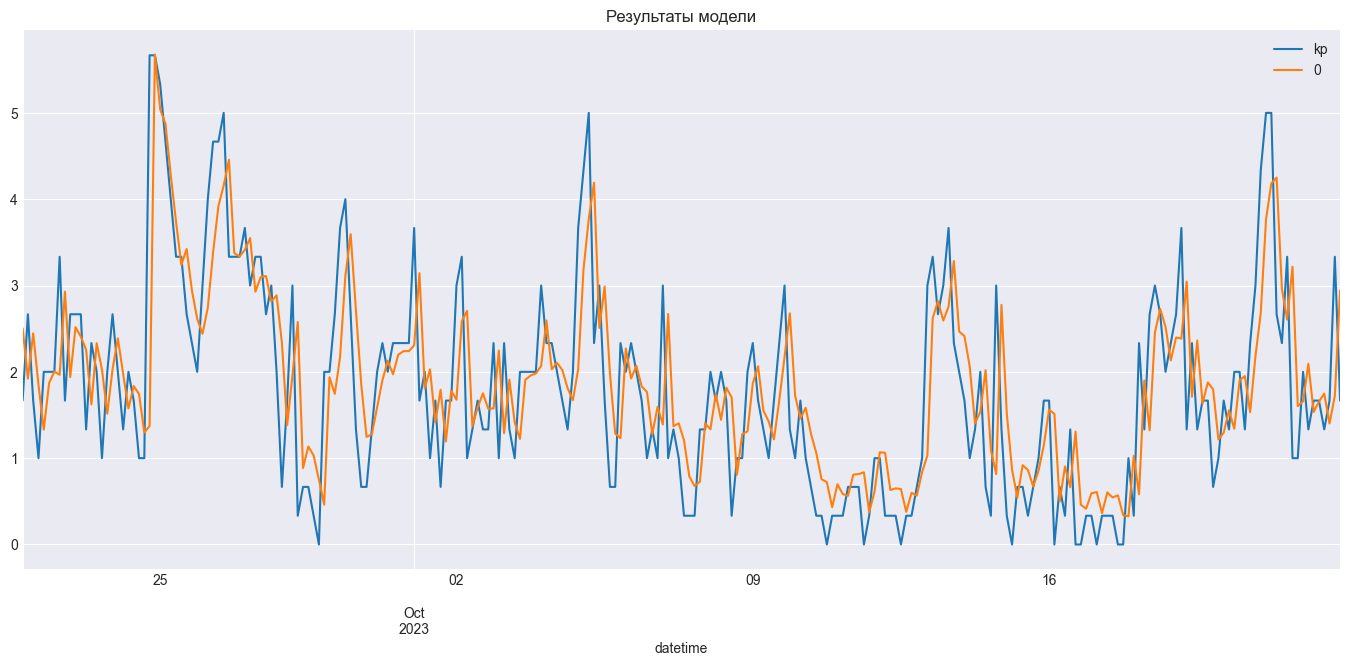

In [6]:
vizualization(y_test, pred)

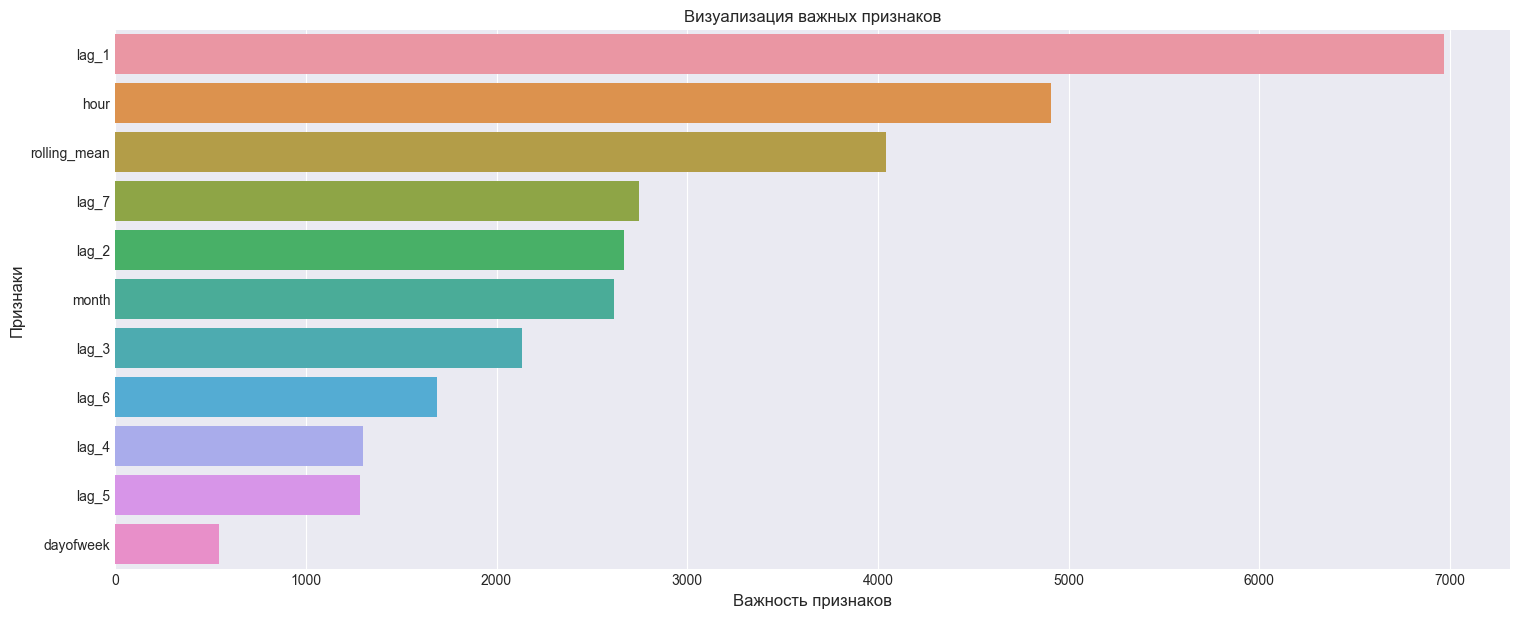

In [7]:
make_features(model)

In [8]:
mlflow.set_experiment(experiment_name='LGBM')

with mlflow.start_run(run_name=f'lag_end = {LAG_END}, rolling_mean_size = {ROLLING_MEAN}'):
    mlflow.log_params(study.best_params)
    mlflow.log_params({'lag_end': LAG_END, 'rolling_mean': ROLLING_MEAN})
    mlflow.log_metrics({
        'rmse' : rmse(y_test, pred), 
        'r2': r2_score(y_test, pred),  
        'max_error': max_error(y_test, pred)})
    mlflow.lightgbm.autolog()
    mlflow.lightgbm.log_model(model, 'model')
    

2023/10/23 12:24:59 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.
c:\Users\tolya\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
